In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, glob, os, imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import helper.canon_supervised_dataset as dset
import helper.post_processing as pp
import helper.utils as ut
import matplotlib
from skimage import exposure
matplotlib.rcParams.update({'font.size': 22})

# Video denoising in starlight example
In this notebook, we load in our pretrained denoiser and denoise video sequences from our submillilux dataset. You can use this notebook to explore the dataset and check out the denoiser performance on a variety of scenes. 

## Load in saved model

In [3]:
base_folder = 'saved_models/'

chkp_path = 'video_denoiser'
args5, model5 = ut.load_from_checkpoint(base_folder + chkp_path)

loading from checkpoint
loading FastDVDnet HR
distributed
resuming from checkoint, epoch: 817


## Load in video clip
You can load in a video clip from our full dataset (92GB), or from our condensed dataset (only a few short clips, 1.3GB). Choose which clip to use below, and make sure to update the `folder_name` to match the location of your dataset. By default, we load in 16 images at a time, but you can load in more or fewer by changing `num_to_load`, as well as `start_ind` to refer to which frame of the video to start with (only relevant if using the full dataset).

A brief description of the videos from the condensed dataset are summarized below. The full description can be found [here](https://drive.google.com/drive/folders/1KFXAoJ8Hbtfb7g-WPex-rt8dJsbqZ7sk?usp=sharing).

|ID | Description| 
| --- | --- |
|43 | Two people sitting in chairs, drinking tea, and stargazing|
|8|Person playing volleyball|
|10|Umbrella spinning (shooting star)|
|7|Person with flowers close by|
|21|Flags waving in the wind (shooting star)|
|32|Person dancing with scarf|
|13|3 people dancing the macarena|
|5|Group of people walking around |
|6|Person dancing with flowers far away.|
|24|Swing dancing|
|26|Two people clapping hands|
|40|Person dancing with umbrella|


In [4]:
seq_id = 8
folder_name = 'data/starlight_dataset_condensed/'
start_ind = 0 
num_to_load = 'all' # 16 # 'all' 


noisy_video = ut.load_video_seq(folder_name, seq_id, start_ind, num_to_load)

loading  16 frames


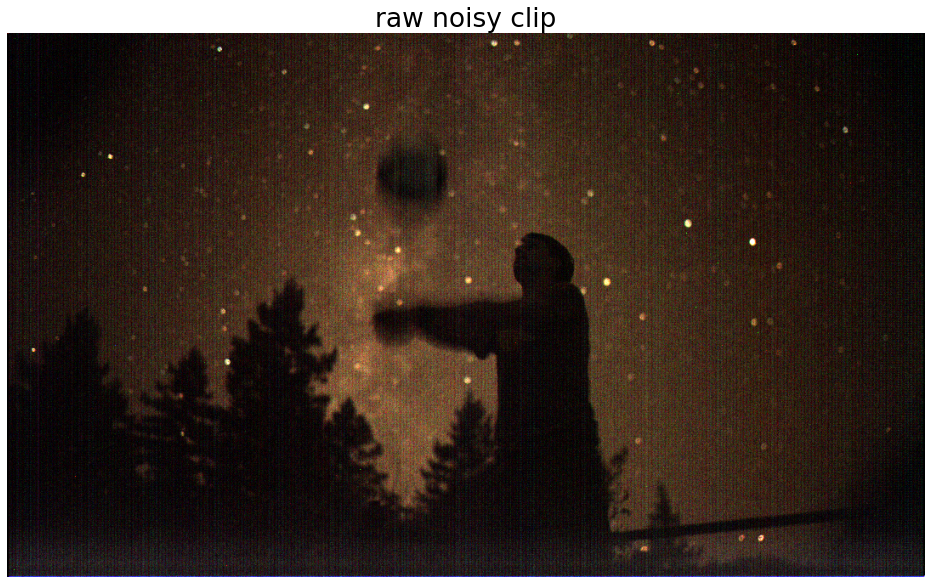

In [5]:
ind = 9
plt.figure(figsize = (20,10))
plt.imshow(noisy_video[ind][...,0:3]); 
plt.axis('off');
plt.title('raw noisy clip');

In [6]:
noisy_video.shape

(16, 640, 1080, 4)

In [7]:
ut.plt3D(noisy_video)

interactive(children=(IntSlider(value=1, description='r', max=15), Output()), _dom_classes=('widget-interact',…

/homes/kmonakho/anaconda3/envs/starlight/lib/python3.9/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


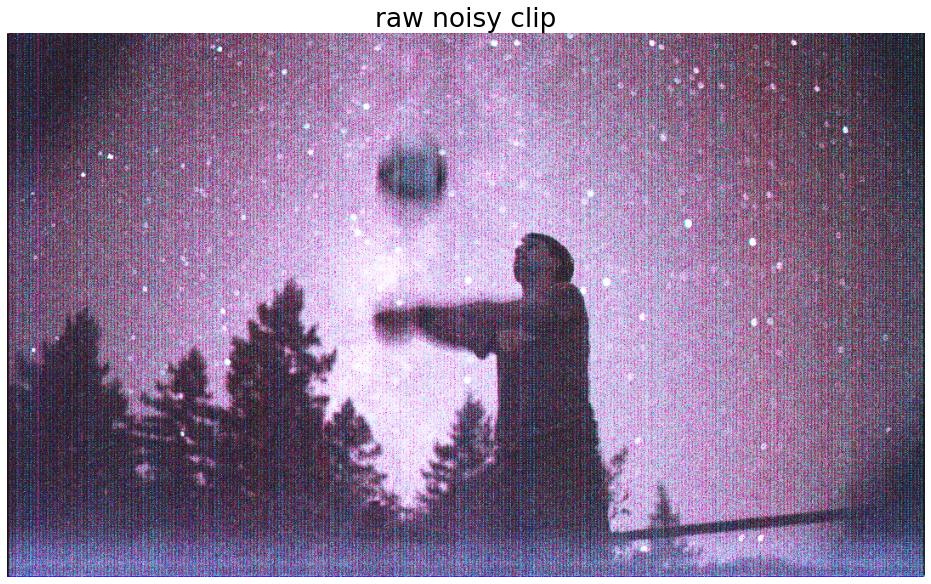

In [8]:
ind = 9
plt.figure(figsize = (20,10))
plt.imshow(exposure.equalize_hist(pp.process(noisy_video[ind][...,0:3], [pp.white_balance, pp.clip,pp.gamma]))); 
plt.axis('off');
plt.title('raw noisy clip');

## Denoise video sequence

In [9]:
tt = dset.ToTensor()
sample = {'noisy_input': noisy_video}
sample = tt(sample)

args_list = [args5]
models_to_test = [model5]
device = 'cuda:0'

converting to tensor
done converting to tensor


In [10]:
out_plt = ut.run_denoiser(sample, args_list, models_to_test, device)

(-0.5, 1659.5, 1279.5, -0.5)

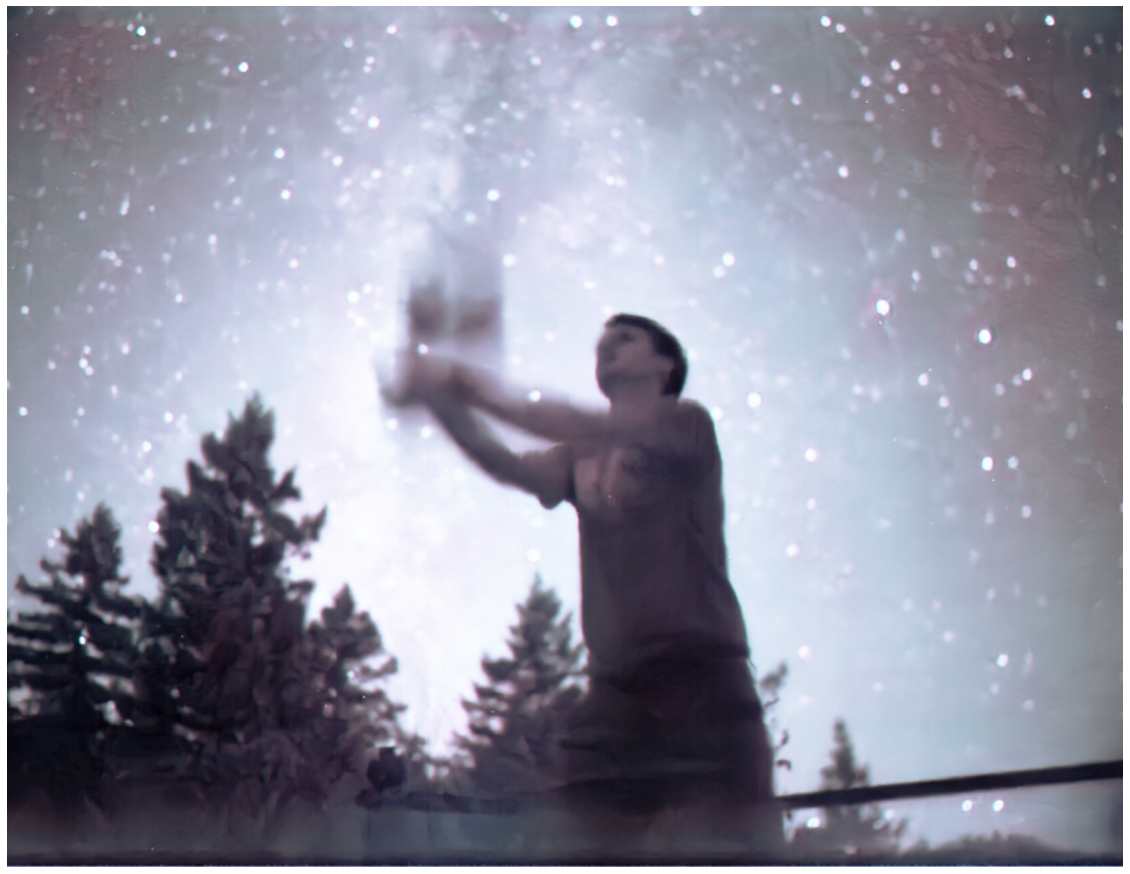

In [11]:
ind = 3
plt.figure(figsize = (20,20))
im_ours = pp.process(out_plt[ind]**(2.2), [pp.bayer_bilinear, pp.white_balance, pp.clip,pp.gamma])
if seq_id not in [21, 26, 22]:
    im_ours = exposure.equalize_hist(im_ours)

plt.imshow(im_ours[:,300:-200]);
plt.axis('off')

In [12]:
im_video = np.empty_like(out_plt[...,0:3])
for i in range(0, out_plt.shape[0]):
    im_video[i] = pp.process(out_plt[i]**(2.2), [pp.white_balance, pp.clip,pp.gamma])
    if seq_id not in [21, 26]:
        im_video[i] = exposure.equalize_hist(im_video[i])

In [13]:
ut.plt3D(np.clip(im_video[:,:,150:-100,0:3],0,1))

interactive(children=(IntSlider(value=1, description='r', max=10), Output()), _dom_classes=('widget-interact',…

## Save video clip as gif

In [15]:
if not os.path.exists('saved_videos/'):
    os.mkdir('saved_videos/')
images = []
for i in range(0,im_video.shape[0]):
    images.append((im_video[i]*255).astype('uint8'))
imageio.mimsave('saved_videos/' + str(seq_id) + '_denoised.gif', images)